In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# functions from here: https://github.com/atiselsts/uniswap-v3-liquidity-math/blob/master/uniswap-v3-liquidity-math.py
def get_liquidity_0(x, sa, sb):
    return x * sa * sb / (sb - sa)

def get_liquidity_1(y, sa, sb):
    return y / (sb - sa)

def get_liquidity(x, y, sp, sa, sb):
    if sp <= sa:
        liquidity = get_liquidity_0(x, sa, sb)
    elif sp < sb:
        liquidity0 = get_liquidity_0(x, sp, sb)
        liquidity1 = get_liquidity_1(y, sa, sp)
        liquidity = min(liquidity0, liquidity1)
    else:
        liquidity = get_liquidity_1(y, sa, sb)
    return liquidity

def calculate_x(L, sp, sa, sb):
    sp = max(min(sp, sb), sa)     # if the price is outside the range, use the range endpoints instead
    return L * (sb - sp) / (sp * sb)

def calculate_y(L, sp, sa, sb):
    sp = max(min(sp, sb), sa)     # if the price is outside the range, use the range endpoints instead
    return L * (sp - sa)

def calculateAmounts(p, a, b, x, y, P1):
    sp = p ** 0.5
    sa = a ** 0.5
    sb = b ** 0.5
    L = get_liquidity(x, y, sp, sa, sb)

    sp1 = P1 ** 0.5

    sp = max(min(sp, sb), sa)
    sp1 = max(min(sp1, sb), sa)

    delta_p = sp1 - sp
    delta_inv_p = 1/sp1 - 1/sp
    delta_x = delta_inv_p * L
    delta_y = delta_p * L
    x1 = x + delta_x
    y1 = y + delta_y
    
    return x1, y1


def find_max_x2(p, a, b, vMax): # KZ: find_max_x using brute force method, could cost a large gas fee. and find_max_x2 has the same solution, with less calculation cost
    sp = p ** 0.5
    sa = a ** 0.5
    sb = b ** 0.5
    x2 = vMax/((sp-sa)*sp*sb/(sb-sp)+p)
    return x2

x2=find_max_x2(1000, 800, 1200, 1000)

In [3]:
# KZ: find_equal_pnl_values using brute force method, could cost a large gas fee. and find_equal_pnl_values2 has the same solution, with less calculation cost
# KZ: Moreover, the find_equal_pnl_values2 has better accuracy
def find_equal_pnl_values2(p, a, b, P1, short_price, maximumValue):
    # Calculate PNL_V3
    Virturl_LP=1000 

    x = find_max_x2(p, a, b, Virturl_LP)  # KZ: what's x at p
    y = Virturl_LP - x * p
    x1, y1 = calculateAmounts(p, a, b, x, y, P1)
    value = x * p + y
    value1 = x1 * P1 + y1
    PNL_V3 = value1 - value  # KZ: the calculate imp loss

   
    # Calculate PNL_short position
    Virturl_Short=PNL_V3/(P1-short_price)*short_price
    print("x0 = {:.2f}".format(PNL_V3))
    print("y0 = {:.2f}".format(Virturl_Short))
    
    initial_portfolio_value_v3=Virturl_LP
    initial_portfolio_value_short=Virturl_Short

    return initial_portfolio_value_v3, initial_portfolio_value_short

## Calculating Impermanent Loss

* p = current price
* a = lower price bound for LP position
* b = upper price bound for LP position

In [4]:
# Test
p = 1570 # current price
a = round(p - (p * 0.03)) # lower price 10% below current price 
b = round(p + (p * 0.03)) # upper price 10% above current price 
short_price = p
maximumPortfolioValue = 1000  # initial value of the porfolio

print(a,b)

1523 1617


x0 = -22.40
y0 = 748.21
initial_portfolio_value_v3Lower = 1000.00
initial_portfolio_value_shortLower = 748.21
x0 = 7.32
y0 = 244.47
initial_portfolio_value_v3Upper = 1000.00
initial_portfolio_value_shortUpper = 244.47
initial_portfolio_value_v3Mid = 668.30
initial_portfolio_value_shortMid = 331.70


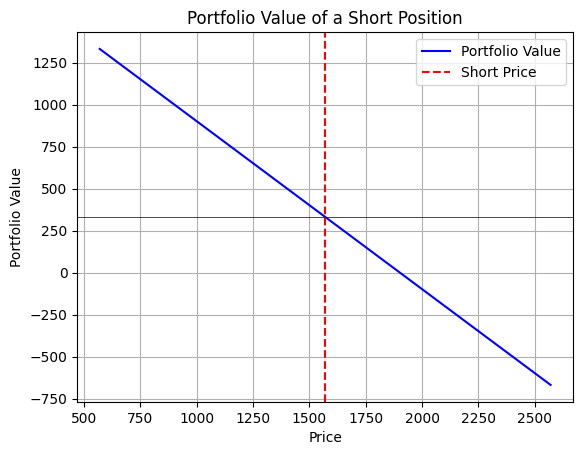

In [5]:
initial_portfolio_value_v3Lower, initial_portfolio_value_shortLower = find_equal_pnl_values2(p, a, b, a, short_price, maximumPortfolioValue)
print("initial_portfolio_value_v3Lower = {:.2f}".format(initial_portfolio_value_v3Lower))
print("initial_portfolio_value_shortLower = {:.2f}".format(initial_portfolio_value_shortLower))

initial_portfolio_value_v3Upper, initial_portfolio_value_shortUpper = find_equal_pnl_values2(p, a, b, b, short_price, maximumPortfolioValue)
print("initial_portfolio_value_v3Upper = {:.2f}".format(initial_portfolio_value_v3Upper))
print("initial_portfolio_value_shortUpper = {:.2f}".format(initial_portfolio_value_shortUpper))

# my suggestion to select hedge possiton, Average of lower case and upper case. It is not beautiful but simple. 
initial_portfolio_value_v3=maximumPortfolioValue*(initial_portfolio_value_v3Lower+initial_portfolio_value_v3Upper)/(initial_portfolio_value_v3Lower+initial_portfolio_value_shortLower+initial_portfolio_value_v3Upper+initial_portfolio_value_shortUpper)
initial_portfolio_value_short=maximumPortfolioValue-initial_portfolio_value_v3
print("initial_portfolio_value_v3Mid = {:.2f}".format(initial_portfolio_value_v3))
print("initial_portfolio_value_shortMid = {:.2f}".format(initial_portfolio_value_short))

# token0 and token1 amounts given initial_portfolio_value_v3 and price
vMax = initial_portfolio_value_v3 # initial portfolio value

x = find_max_x2(p, a, b, vMax)
y = vMax - x * p

# Constants
initial_portfolio_value = initial_portfolio_value_short # using value from above

# Price range for our graph
prices = np.linspace(p-1000, p+1000, 100)

# Calculate P&L for each price point
profit_loss = short_price - prices

# Calculate Portfolio Value for each P&L
portfolio_values = initial_portfolio_value + profit_loss

# Plotting
plt.plot(prices, portfolio_values, label='Portfolio Value', color='blue')
plt.axhline(initial_portfolio_value, color='black',linewidth=0.5)
plt.axvline(short_price, color='red', linestyle='--', label='Short Price')
plt.title('Portfolio Value of a Short Position')
plt.xlabel('Price')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# token0 and token1 amounts given initial_portfolio_value_v3 and price
vMax = initial_portfolio_value_v3 # initial portfolio value

x = find_max_x2(p, a, b, vMax)
y = vMax - x * p
print("Maximum # of ETH {:.3f}".format(x))
print("Maximum # of USDC {:.3f}".format(y))

Maximum # of ETH 0.210
Maximum # of USDC 339.113


In [7]:
## PLOT IL
x_1 = find_max_x2(p, a, b, maximumPortfolioValue)
y_1 = maximumPortfolioValue - x_1 * p

P1_values_1 = []
value_values_1 = []

for P1 in range(p-1000, p+1000):
    x1, y1 = calculateAmounts(p, a, b, x_1, y_1, P1)  # Calculate x1 and y1 based on the given function
    value = x1 * P1 + y1  # Calculate the value based on the given formula
    
    P1_values_1.append(P1)
    value_values_1.append(value)

# Create empty lists to store values for the second plot
P1_values_2 = []
value_values_2 = []

for P1 in range(p-1000, p+1000):
    x1, y1 = calculateAmounts(p, a, b, x, y, P1)  # Calculate x1 and y1 based on the given function
    value = x1 * P1 + y1  # Calculate the value based on the given formula
    
    profit_loss = (short_price - P1) / short_price
    PNL_short = initial_portfolio_value_short * profit_loss + initial_portfolio_value_short
    
    value1 = value + PNL_short

    P1_values_2.append(P1)
    value_values_2.append(value1)


index_at_a = P1_values_1.index(a)
index_at_b = P1_values_1.index(b)
percent_difference_at_a = ((value_values_1[index_at_a] - p) / p) * 100
percent_difference_at_b = ((value_values_1[index_at_b] - p) / p) * 100


In [8]:
x1, y1 = calculateAmounts(p, a, b, x, y, P1)  # Calculate x1 and y1 based on the given function



In [9]:
profit_loss = (short_price - P1) / short_price
PNL_short = initial_portfolio_value_short * profit_loss + initial_portfolio_value_short

In [10]:
print(profit_loss)
print(PNL_short)

-0.6363057324840764
120.63855615085029


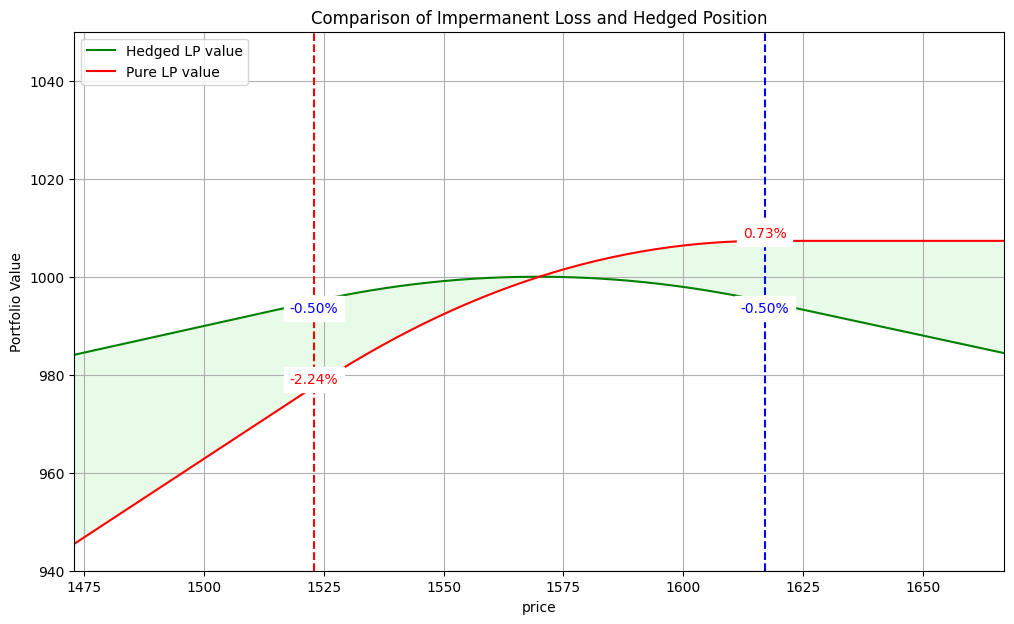

lower lp bound 1523
upper lp bound 1617
short position 331.70321043228535
initial portfolio value 1000
short position value to total position value 33.17 %


In [11]:
plt.figure(figsize=(12, 7))

# Plot the data for both functions
plt.plot(P1_values_2, value_values_2, linestyle='-', label="Hedged LP value", color='Green')
plt.plot(P1_values_1, value_values_1, linestyle='-', label="Pure LP value", color='red')

plt.title('Comparison of Impermanent Loss and Hedged Position')
plt.xlabel('price')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.legend(loc="upper left")

# Add vertical dotted lines for points 'a' and 'b'
plt.axvline(x=a, color='r', linestyle='--')
plt.axvline(x=b, color='b', linestyle='--')

# Calculate the percentage difference of each function from p at a and b
percent_diff_1_at_a = ((value_values_1[index_at_a] - maximumPortfolioValue) / maximumPortfolioValue) * 100
percent_diff_1_at_b = ((value_values_1[index_at_b] - maximumPortfolioValue) / maximumPortfolioValue) * 100

percent_diff_2_at_a = ((value_values_2[index_at_a] - maximumPortfolioValue) / maximumPortfolioValue) * 100
percent_diff_2_at_b = ((value_values_2[index_at_b] - maximumPortfolioValue) / maximumPortfolioValue) * 100

# Place the percentage differences on the chart
# Get the max and min between the two values for each point 'a' and 'b'
plt.text(a, value_values_1[index_at_a], f'{percent_diff_1_at_a:.2f}%', color='r', ha='center', va='bottom', backgroundcolor='white')
plt.text(b, value_values_1[index_at_b], f'{percent_diff_1_at_b:.2f}%', color='r', ha='center', va='bottom', backgroundcolor='white')

plt.text(a, value_values_2[index_at_a], f'{percent_diff_2_at_a:.2f}%', color='blue', ha='center', va='top', backgroundcolor='white')
plt.text(b, value_values_2[index_at_b], f'{percent_diff_2_at_b:.2f}%', color='blue', ha='center', va='top', backgroundcolor='white')

# Shade the difference areas
# where_condition_1 = [value != maximumPortfolioValue for value in value_values_1]
# plt.fill_between(P1_values_1, value_values_1, maximumPortfolioValue, where=where_condition_1, interpolate=True, color='grey', alpha=0.2)
where_condition_2 = [value < p or value > p for value in value_values_2]
plt.fill_between(P1_values_2, value_values_1, value_values_2, where=where_condition_2, interpolate=True, color='lightgreen', alpha=0.2)

plt.xlim(a - 50, b + 50)
plt.ylim(940, 1050)

# Show the plot
plt.show()

short_position_percentage = (initial_portfolio_value_short / maximumPortfolioValue) * 100

print("lower lp bound", a)
print("upper lp bound", b)

print("short position", initial_portfolio_value_short)
print("initial portfolio value", maximumPortfolioValue)
print("short position value to total position value", round(short_position_percentage, 2), "%")